## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare MNIST dataset


In [11]:
batch_size = 64
num_channels = 1
image_size = 64
latent_dim = 128

In [3]:
def resize_image(image):
    return tf.image.resize(image, size=(image_size, image_size))

In [4]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.map(resize_image)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)


2022-04-01 16:43:15.038568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:43:15.042809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:43:15.043533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:43:15.066457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
for batch_samples in dataset.take(1):
    print(batch_samples.shape)
    break

(64, 64, 64, 1)


Let's display a sample image:

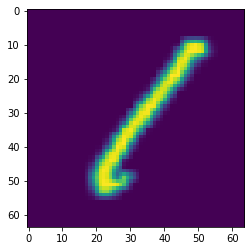

In [6]:

for x in dataset:
#     plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [7]:
def downsample(x, filters, kernel_size, strides, padding):
    x = layers.Conv2D(filters, kernel_size=kernel_size, 
                      strides=strides, padding=padding)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)    
    return x


def get_discriminator(image_size, num_channels):
    
    inp = keras.Input(shape=(image_size, 
                             image_size, 
                             num_channels))
    
    x = downsample(inp, filters=64, kernel_size=4, 
                   strides=2, padding="same")
    x = downsample(x, filters=128, kernel_size=4, 
                   strides=2, padding="same")
    x = downsample(x, filters=128, kernel_size=4, 
                   strides=2, padding="same")
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)
    return model

In [8]:
discriminator = get_discriminator(image_size, num_channels)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0     

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [9]:
def upsample(x, filters, kernel_size, strides, padding):
    x = layers.Conv2DTranspose(filters, 
                               kernel_size=kernel_size, 
                               strides=strides, 
                               padding=padding)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x


def get_generator(latent_dim, image_size, num_channels):
    last_disc_dim = image_size//8
    
    inp = keras.Input(shape=(latent_dim,))
    x = layers.Dense(last_disc_dim * last_disc_dim* 128)(inp)
    x = layers.Reshape((last_disc_dim, last_disc_dim, 128))(x)
    
    x = upsample(x, filters=128, kernel_size=4, 
                 strides=2, padding='same')
    x = upsample(x, filters=256, kernel_size=4, 
                 strides=2, padding='same')
    x = upsample(x, filters=512, kernel_size=4, 
                 strides=2, padding='same')
    
    x = layers.Conv2D(num_channels, kernel_size=5, 
                      padding="same", activation="sigmoid")(x)
    
    model = keras.models.Model(inputs=inp, outputs=x)    
    return model

In [12]:
generator = get_generator(latent_dim, image_size, num_channels)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                 

## Loss

In [13]:
bce_obj = keras.losses.BinaryCrossentropy()
def loss_fn(labels, predictions):
    loss = bce_obj(labels, predictions)
    return loss

In [14]:
d_optimizer=keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer=keras.optimizers.Adam(learning_rate=0.0001)

## Checkpoints

In [15]:
checkpoint_dir = 'DCGAN_CKPT'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(d_optimizer=d_optimizer,
                                 g_optimizer=g_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train

In [16]:
def generated_image(generator, latent_dim):
    num_img = 10
    random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
    generated_images = generator(random_latent_vectors)
    generated_images.numpy()
    
    show_list = []
    for i in range(num_img):
        show_list.append(np.squeeze(generated_images[i]))
    
    plt.figure(figsize=(20, 20))
    plt.imshow(np.concatenate(show_list, axis=1), cmap="Greys_r")
    plt.show()

In [17]:
@tf.function(experimental_relax_shapes=True)
def train_step(real_images):
    # Sample random points in the latent space
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator(random_latent_vectors)

    # Combine them with real images
    combined_images = tf.concat([generated_images, real_images], 
                                axis=0)

    # Assemble labels discriminating real from fake images
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], 
                       axis=0)
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))    
    
    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        predictions = discriminator(combined_images)
        d_loss = loss_fn(labels, predictions)
    grads = disc_tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
    
    
    
    
    
    
    
    # Sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_labels = tf.zeros((batch_size, 1))
    
    # Train the generator
    with tf.GradientTape() as gen_tape:
        predictions = discriminator(generator(random_latent_vectors))
        g_loss = loss_fn(misleading_labels, predictions)
    grads = gen_tape.gradient(g_loss, generator.trainable_weights)    
    g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))    
    
    return d_loss, g_loss

In [18]:
def fit(train_ds, epochs):
    for epoch in range(epochs):
        for real_images in train_ds:                      
            d_loss, g_loss = train_step(real_images)
        
        checkpoint.save(file_prefix = checkpoint_prefix)
        generated_image(generator, latent_dim)
        print('epoch: {} d_loss {}  g_loss: {}'.format(epoch, d_loss, g_loss))

Epoch 1/50


2022-04-01 09:16:07.062766: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-04-01 09:16:07.311983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1094/1094 [==============================] - ETA: 0s - d_loss: 3.2288 - g_loss: 94.9488

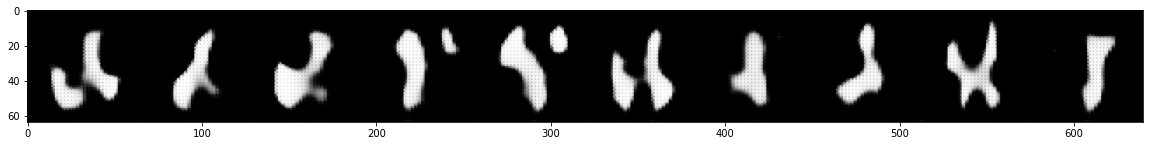

1094/1094 [==============================] - 116s 104ms/step - d_loss: 3.2288 - g_loss: 94.9488
Epoch 2/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.8078 - g_loss: 1.6885

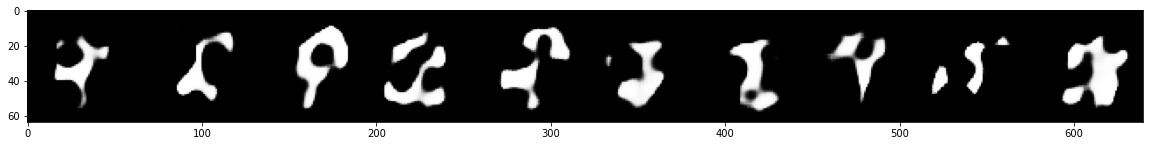

1094/1094 [==============================] - 114s 104ms/step - d_loss: 0.8078 - g_loss: 1.6885
Epoch 3/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5629 - g_loss: 1.2532

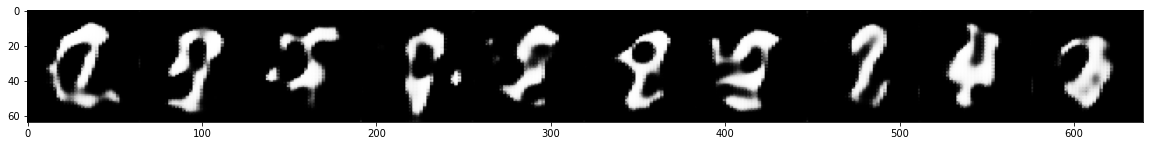

1094/1094 [==============================] - 114s 105ms/step - d_loss: 0.5629 - g_loss: 1.2532
Epoch 4/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5710 - g_loss: 1.1807

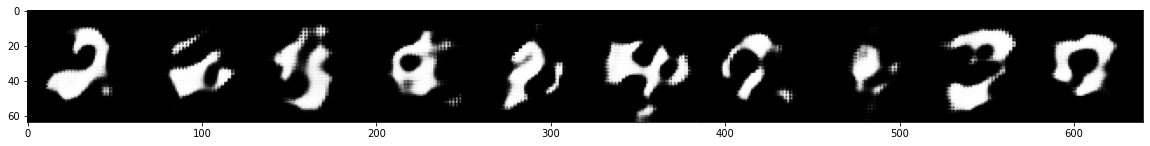

1094/1094 [==============================] - 118s 108ms/step - d_loss: 0.5710 - g_loss: 1.1807
Epoch 5/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5211 - g_loss: 2.0503

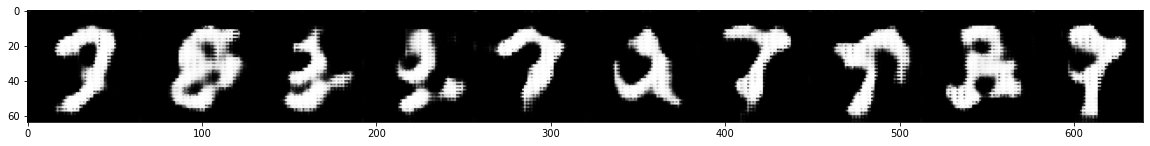

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5211 - g_loss: 2.0503
Epoch 6/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5693 - g_loss: 2.0080

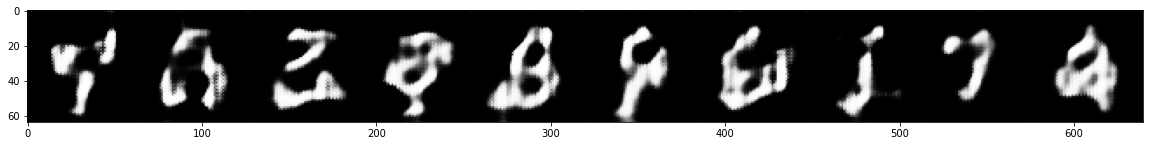

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5693 - g_loss: 2.0080
Epoch 7/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5532 - g_loss: 1.3717

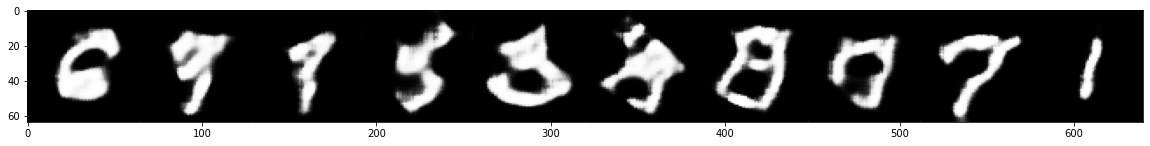

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5532 - g_loss: 1.3717
Epoch 8/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6530 - g_loss: 1.2051

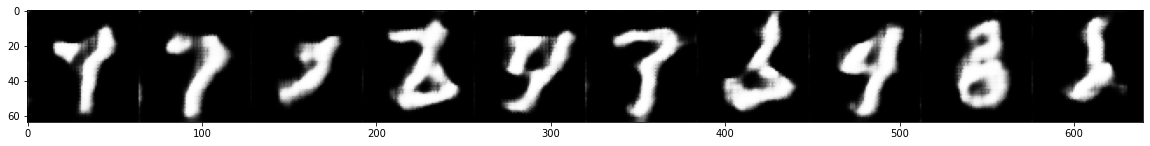

1094/1094 [==============================] - 121s 111ms/step - d_loss: 0.6530 - g_loss: 1.2051
Epoch 9/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6574 - g_loss: 1.1166

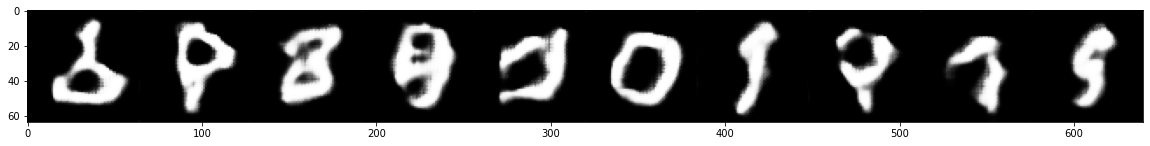

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.6574 - g_loss: 1.1166
Epoch 10/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6711 - g_loss: 0.9754

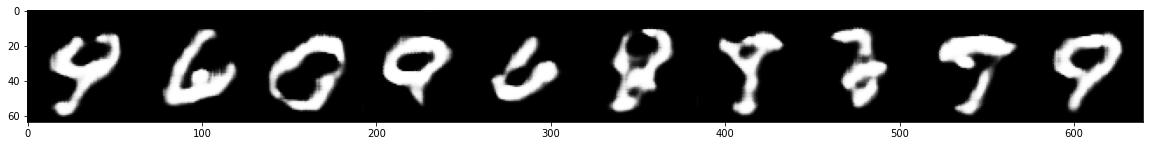

1094/1094 [==============================] - 113s 103ms/step - d_loss: 0.6711 - g_loss: 0.9754
Epoch 11/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6802 - g_loss: 0.8864

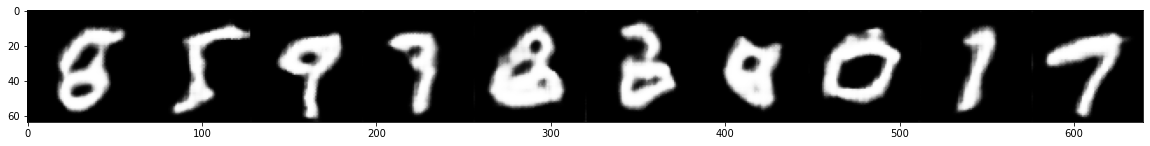

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6802 - g_loss: 0.8864
Epoch 12/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6762 - g_loss: 0.8788

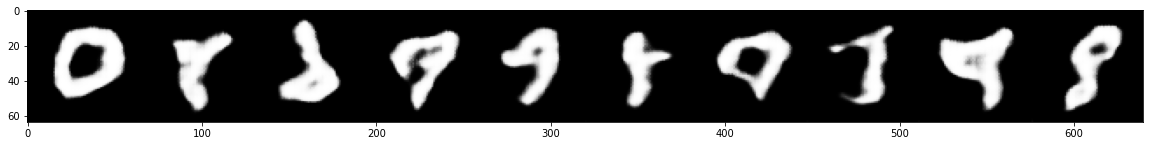

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6762 - g_loss: 0.8788
Epoch 13/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6804 - g_loss: 0.8912

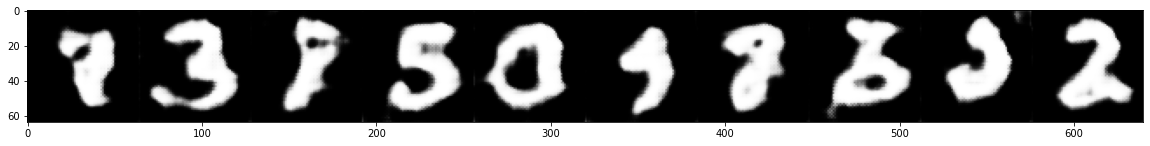

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6804 - g_loss: 0.8912
Epoch 14/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6721 - g_loss: 0.8698

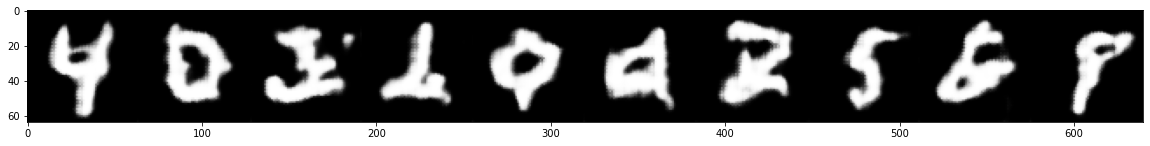

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6721 - g_loss: 0.8698
Epoch 15/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6606 - g_loss: 0.8653

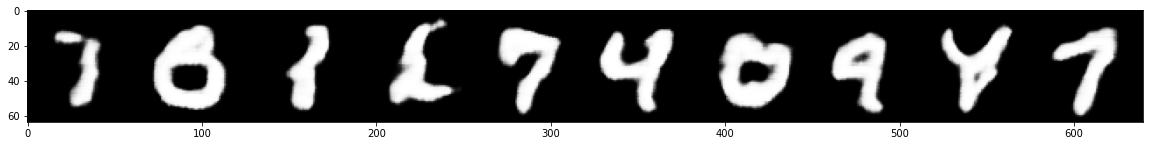

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6606 - g_loss: 0.8653
Epoch 16/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6189 - g_loss: 0.9478

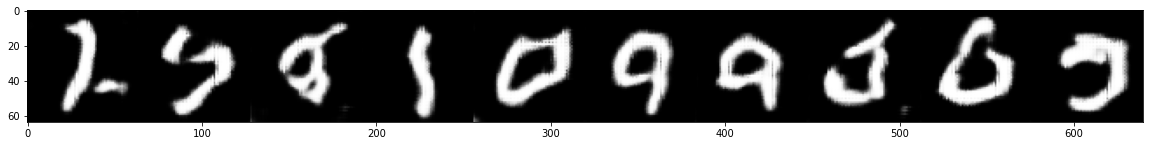

1094/1094 [==============================] - 114s 104ms/step - d_loss: 0.6189 - g_loss: 0.9478
Epoch 17/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6393 - g_loss: 0.9198

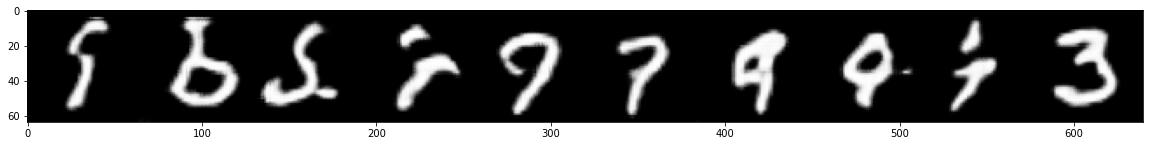

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.6393 - g_loss: 0.9198
Epoch 18/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6421 - g_loss: 0.9105

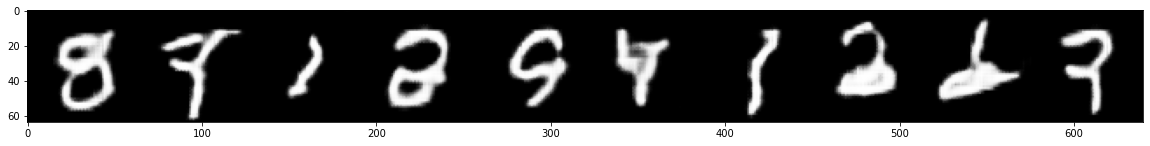

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.6421 - g_loss: 0.9105
Epoch 19/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6381 - g_loss: 0.9003

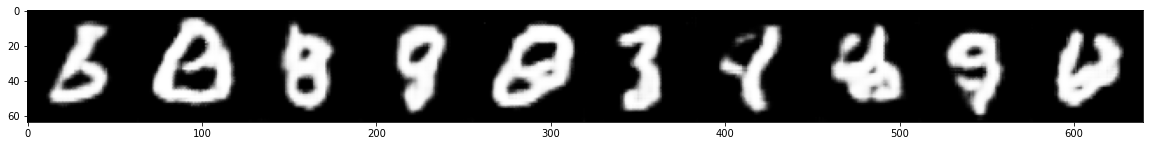

1094/1094 [==============================] - 117s 107ms/step - d_loss: 0.6381 - g_loss: 0.9003
Epoch 20/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6300 - g_loss: 0.9279

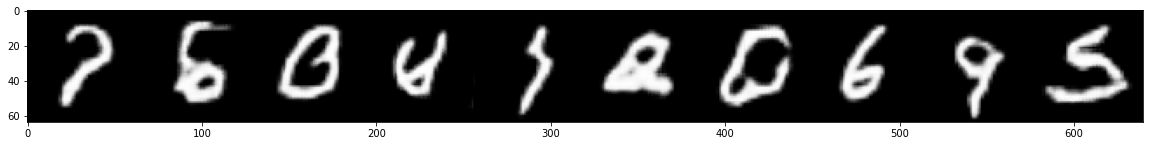

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.6300 - g_loss: 0.9279
Epoch 21/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6223 - g_loss: 0.9466

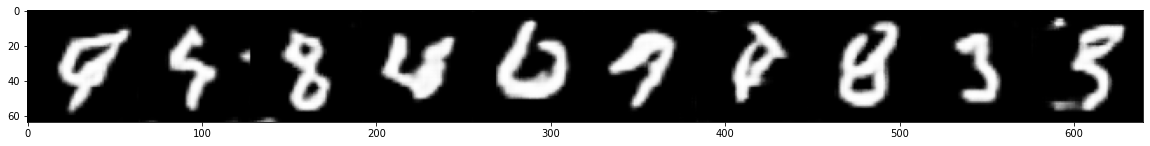

1094/1094 [==============================] - 113s 103ms/step - d_loss: 0.6223 - g_loss: 0.9466
Epoch 22/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6169 - g_loss: 0.9644

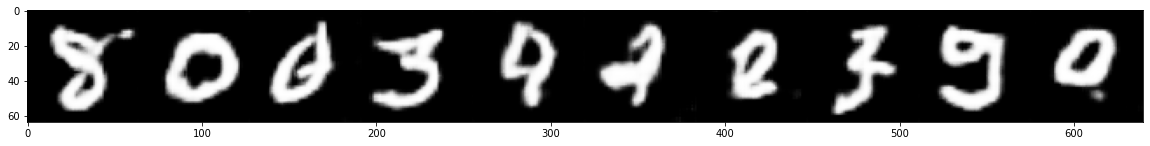

1094/1094 [==============================] - 113s 103ms/step - d_loss: 0.6169 - g_loss: 0.9644
Epoch 23/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6100 - g_loss: 0.9786

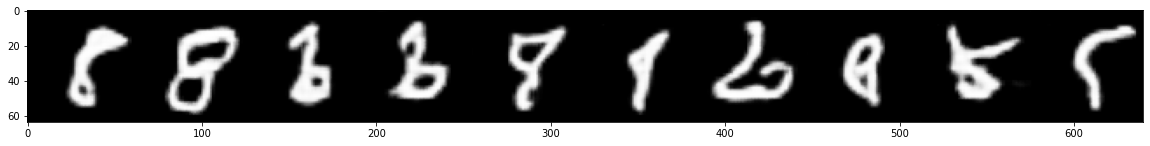

1094/1094 [==============================] - 113s 103ms/step - d_loss: 0.6100 - g_loss: 0.9786
Epoch 24/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6064 - g_loss: 0.9838

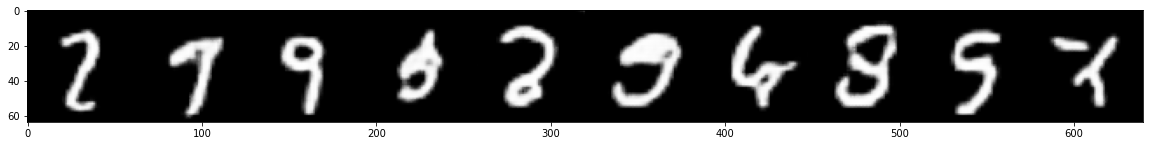

1094/1094 [==============================] - 114s 104ms/step - d_loss: 0.6064 - g_loss: 0.9838
Epoch 25/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6003 - g_loss: 0.9926

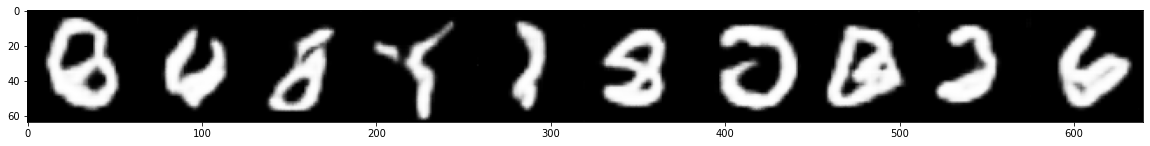

1094/1094 [==============================] - 112s 103ms/step - d_loss: 0.6003 - g_loss: 0.9926
Epoch 26/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5952 - g_loss: 1.0146

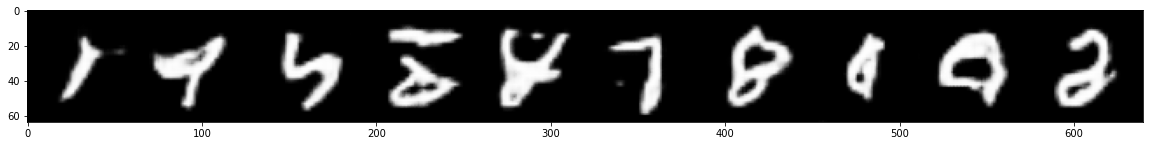

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.5952 - g_loss: 1.0146
Epoch 27/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5938 - g_loss: 1.0101

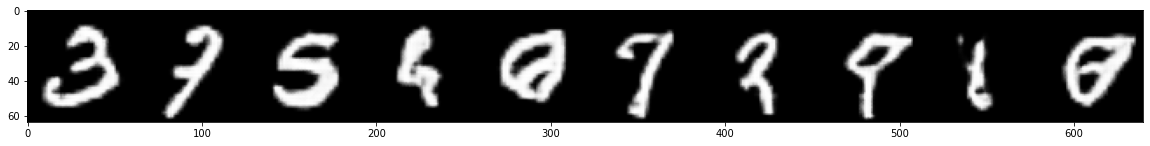

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.5938 - g_loss: 1.0101
Epoch 28/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5914 - g_loss: 1.0397

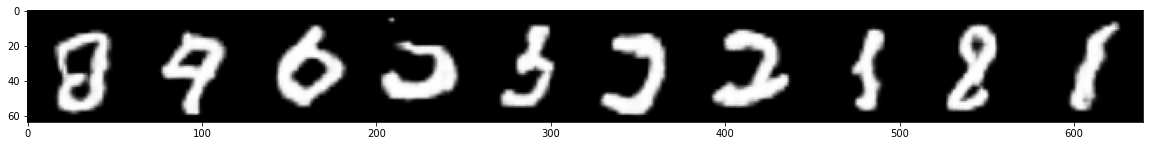

1094/1094 [==============================] - 117s 107ms/step - d_loss: 0.5914 - g_loss: 1.0397
Epoch 29/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5876 - g_loss: 1.0407

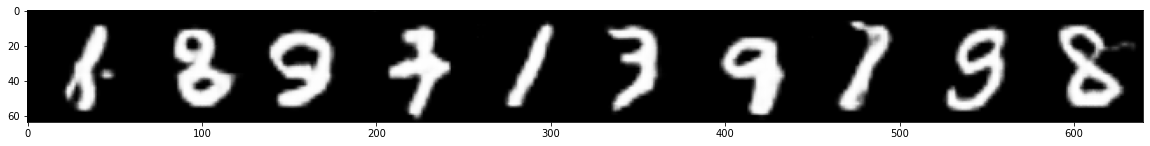

1094/1094 [==============================] - 117s 107ms/step - d_loss: 0.5876 - g_loss: 1.0407
Epoch 30/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5886 - g_loss: 1.0446

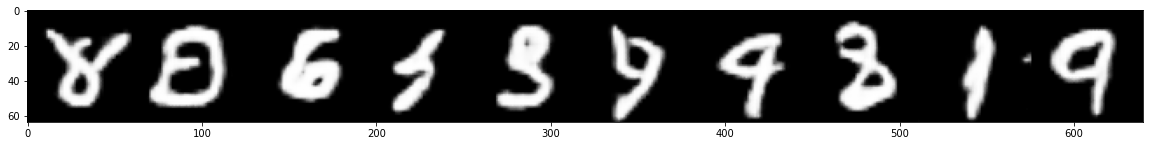

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.5886 - g_loss: 1.0446
Epoch 31/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5870 - g_loss: 1.0581

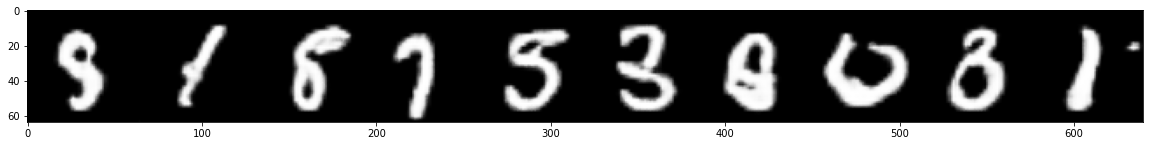

1094/1094 [==============================] - 117s 107ms/step - d_loss: 0.5870 - g_loss: 1.0581
Epoch 32/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5860 - g_loss: 1.0595

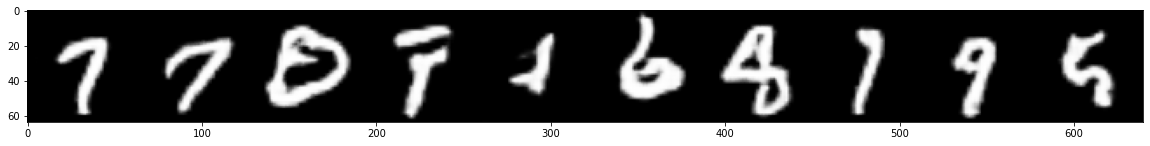

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5860 - g_loss: 1.0595
Epoch 33/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5807 - g_loss: 1.0717

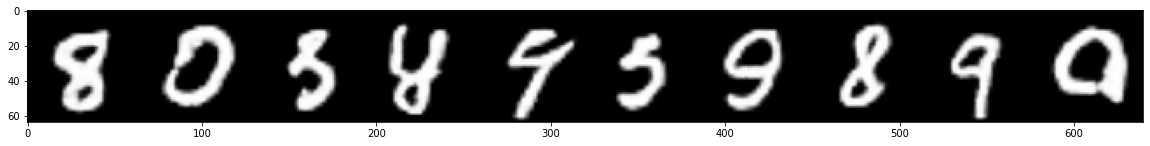

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5807 - g_loss: 1.0717
Epoch 34/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5816 - g_loss: 1.0629

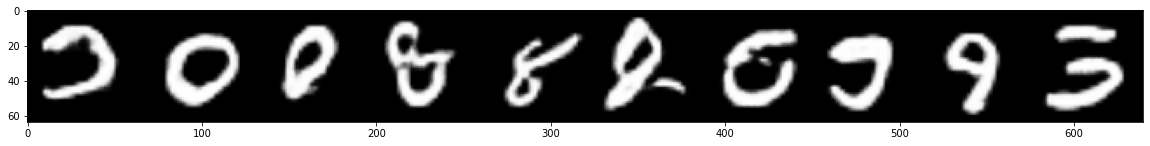

1094/1094 [==============================] - 113s 104ms/step - d_loss: 0.5816 - g_loss: 1.0629
Epoch 35/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5807 - g_loss: 1.0671

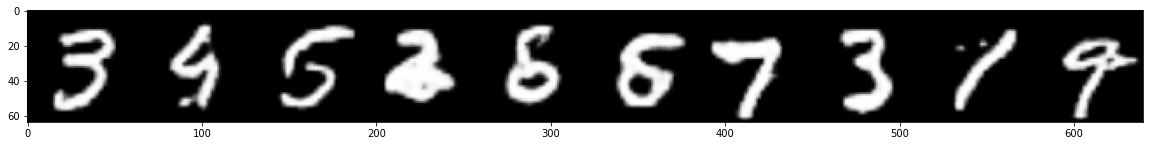

1094/1094 [==============================] - 113s 103ms/step - d_loss: 0.5807 - g_loss: 1.0671
Epoch 36/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5775 - g_loss: 1.0849

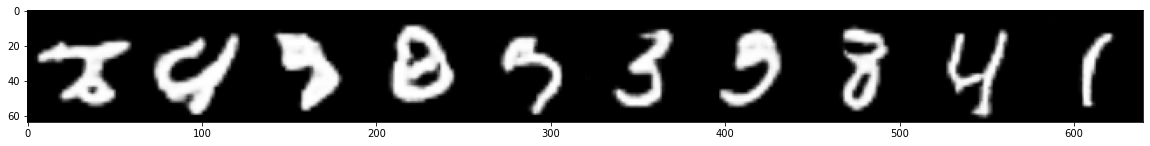

1094/1094 [==============================] - 119s 108ms/step - d_loss: 0.5775 - g_loss: 1.0849
Epoch 37/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5772 - g_loss: 1.0832

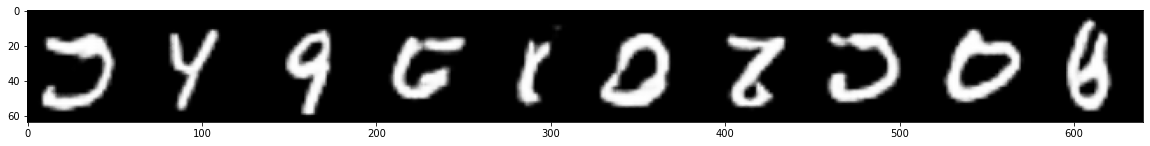

1094/1094 [==============================] - 117s 107ms/step - d_loss: 0.5772 - g_loss: 1.0832
Epoch 38/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5752 - g_loss: 1.0884

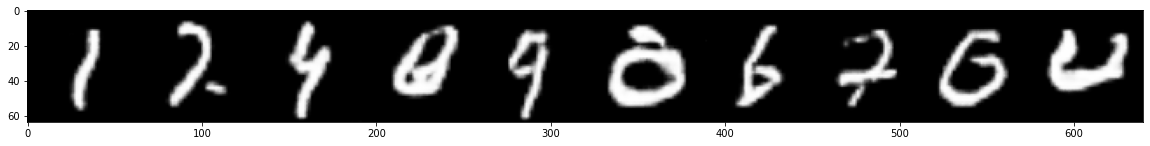

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.5752 - g_loss: 1.0884
Epoch 39/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5735 - g_loss: 1.1139

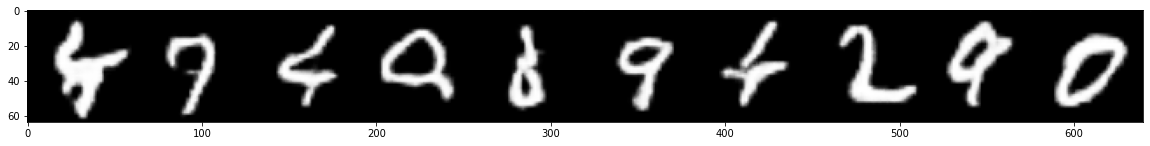

1094/1094 [==============================] - 116s 106ms/step - d_loss: 0.5735 - g_loss: 1.1139
Epoch 40/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5710 - g_loss: 1.1034

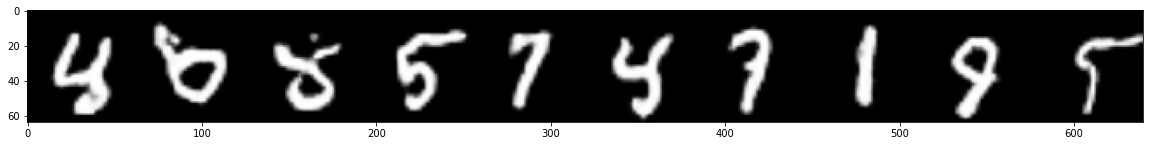

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5710 - g_loss: 1.1034
Epoch 41/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5717 - g_loss: 1.1139

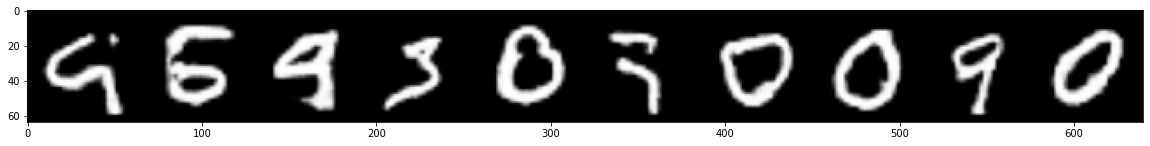

1094/1094 [==============================] - 121s 110ms/step - d_loss: 0.5717 - g_loss: 1.1139
Epoch 42/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5664 - g_loss: 1.1226

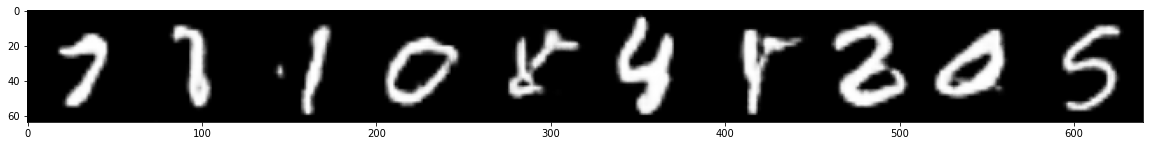

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5664 - g_loss: 1.1226
Epoch 43/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5671 - g_loss: 1.1187

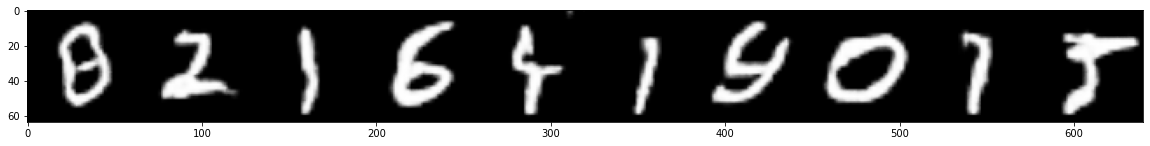

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5671 - g_loss: 1.1187
Epoch 44/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5644 - g_loss: 1.1266

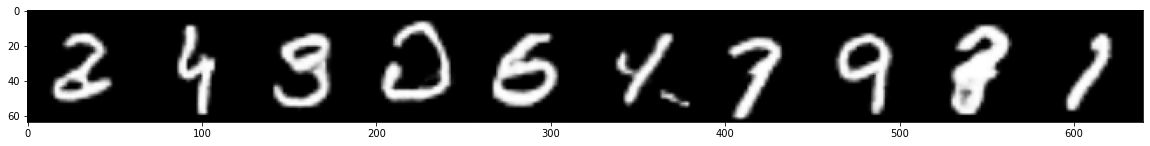

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5644 - g_loss: 1.1266
Epoch 45/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5653 - g_loss: 1.1222

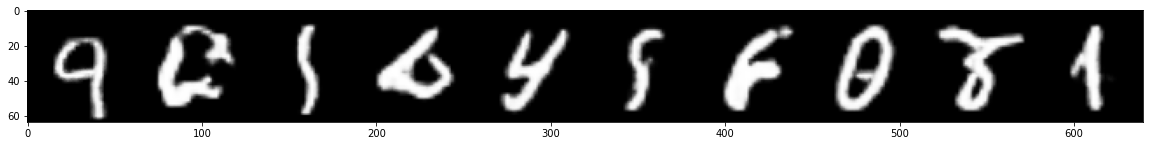

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5653 - g_loss: 1.1222
Epoch 46/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5654 - g_loss: 1.1237

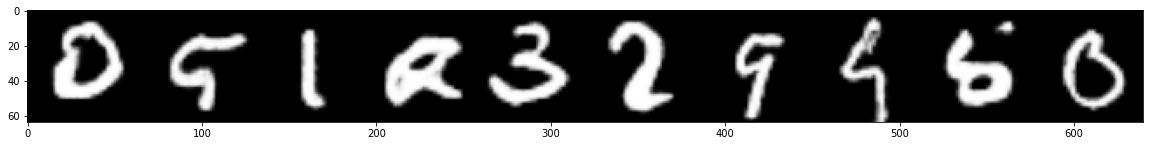

1094/1094 [==============================] - 118s 108ms/step - d_loss: 0.5654 - g_loss: 1.1237
Epoch 47/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5621 - g_loss: 1.1423

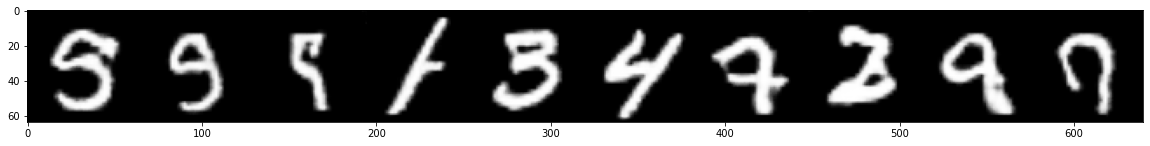

1094/1094 [==============================] - 120s 110ms/step - d_loss: 0.5621 - g_loss: 1.1423
Epoch 48/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5603 - g_loss: 1.1550

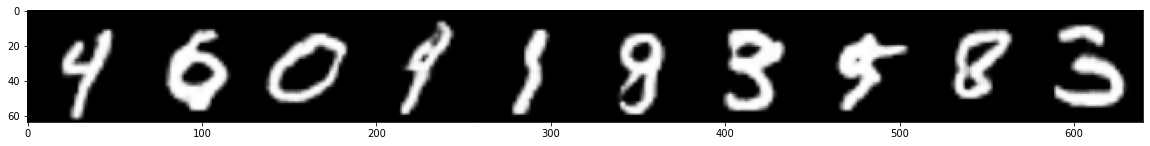

1094/1094 [==============================] - 121s 110ms/step - d_loss: 0.5603 - g_loss: 1.1550
Epoch 49/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5590 - g_loss: 1.1410

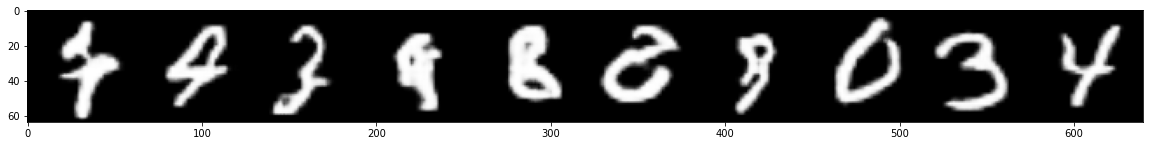

1094/1094 [==============================] - 118s 108ms/step - d_loss: 0.5590 - g_loss: 1.1410
Epoch 50/50
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5568 - g_loss: 1.1500

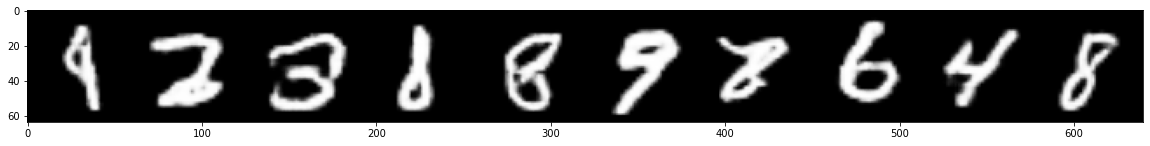

1094/1094 [==============================] - 119s 109ms/step - d_loss: 0.5568 - g_loss: 1.1500


In [11]:
EPOCHS = 151
fit(dataset, EPOCHS)

## Load Weights and Show Results

In [11]:
checkpoint = tf.train.Checkpoint(d_optimizer=d_optimizer,
                                 g_optimizer=g_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)


In [13]:
checkpoint.restore(manager.latest_checkpoint)

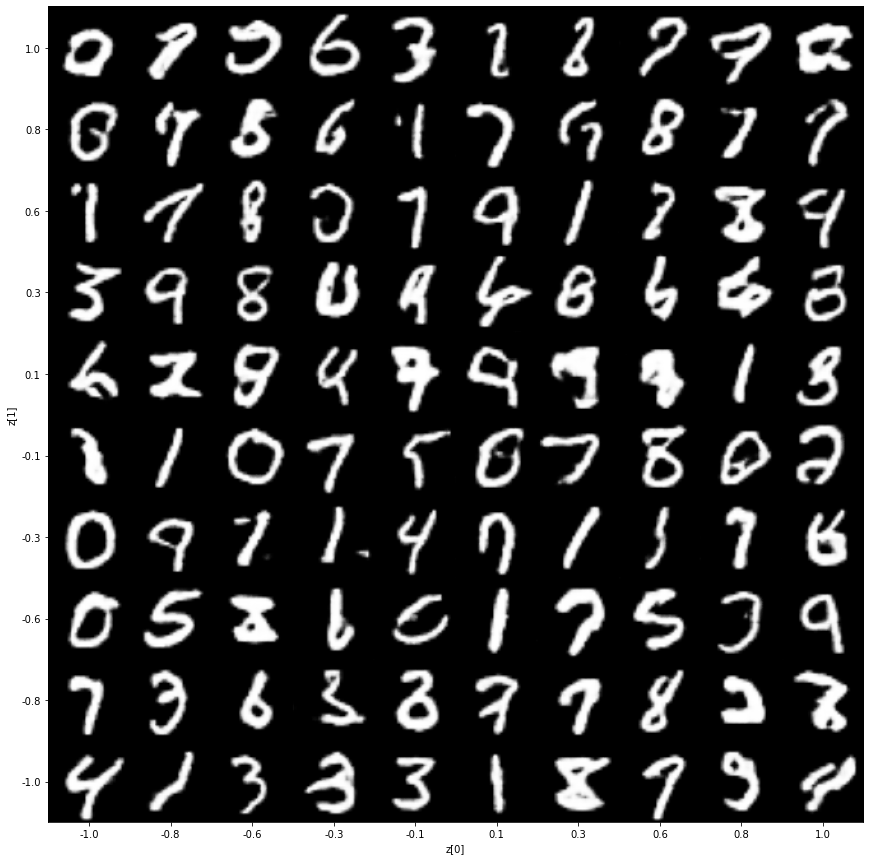

In [14]:
def plot_latent_space(gan, latent_dim, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = image_size
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
#             z_sample = np.array([[xi, yi]])
            random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
            digit = gan.generator.predict(random_latent_vectors)
            digit = digit[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(checkpoint, latent_dim)